In [1]:
import argparse
import datetime
import logging
import os
import sys
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import torch.autograd as tgrad

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

True
cuda


# Data

In [3]:
K = 10
r = 0.035
sigma = 0.2
T = 1
S_range = [0, int(5*K)]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)
M = 100
N = 5000
import utils
samples = {"pde": 5000, "bc":500, "fc":500}

# sample data generated by finite difference method
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = utils.fdm_data(S_range[-1], T, M, N, "500000sample.csv", device)

# Network

In [5]:
class AdaptiveLinear(nn.Linear):
    r"""Applies a linear transformation to the input data as follows
    :math:`y = naxA^T + b`.
    More details available in Jagtap, A. D. et al. Locally adaptive
    activation functions with slope recovery for deep and
    physics-informed neural networks, Proc. R. Soc. 2020.

    Parameters
    ----------
    in_features : int
        The size of each input sample
    out_features : int 
        The size of each output sample
    bias : bool, optional
        If set to ``False``, the layer will not learn an additive bias
    adaptive_rate : float, optional
        Scalable adaptive rate parameter for activation function that
        is added layer-wise for each neuron separately. It is treated
        as learnable parameter and will be optimized using a optimizer
        of choice 
        (self.A is the learnable parameter which is initialized by the 
        self.adaptive rate. To create a learnable parameter for each neuron, 
        it multiplies the self.adaptive rate to the number of input features.)
    adaptive_rate_scaler : float, optional
        Fixed, pre-defined, scaling factor for adaptive activation
        functions
    """
    def __init__(self, in_features, out_features, bias=True, adaptive_rate=None, adaptive_rate_scaler=None):
        super(AdaptiveLinear, self).__init__(in_features, out_features, bias)
        self.adaptive_rate = adaptive_rate
        self.adaptive_rate_scaler = adaptive_rate_scaler
        if self.adaptive_rate:
            self.A = nn.Parameter(self.adaptive_rate * torch.ones(self.in_features))
            if not self.adaptive_rate_scaler:
                self.adaptive_rate_scaler = 10.0
            
    def forward(self, input):
        if self.adaptive_rate:
            return nn.functional.linear(self.adaptive_rate_scaler * self.A * input, self.weight, self.bias)
        return nn.functional.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return (
            f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}, '
            f'adaptive_rate={self.adaptive_rate is not None}, adaptive_rate_scaler={self.adaptive_rate_scaler is not None}'
        )

class Net(nn.Module):
    r"""Neural approximator for the unknown function that is supposed
    to be solved.

    Parameters
    ----------
    sizes : list
        Each element represents the number of neuron per layer
    activation : callable 
        Activation function
    dropout_rate : float, optional
        Dropout rate for regulrization during training process and
        uncertainty quantification by means of Monte Carlo dropout
        procedure while performing evaluation
    adaptive_rate : float, optional
        Scalable adaptive rate parameter for activation function that
        is added layer-wise for each neuron separately. It is treated
        as learnable parameter and will be optimized using a optimizer
        of choice
    adaptive_rate_scaler : float, optional
        Fixed, pre-defined, scaling factor for adaptive activation
        functions
    """
    def __init__(self, sizes, activation, dropout_rate=0.0, adaptive_rate=None, adaptive_rate_scaler=None):
        super(Net, self).__init__()
        self.regressor = nn.Sequential(
            *[
                Net.linear_block(in_features, out_features, activation, dropout_rate, adaptive_rate, adaptive_rate_scaler)
                for in_features, out_features in zip(sizes[:-1], sizes[1:-1])
            ],
            # because the output is the price of the option, we use regular linear transformation     
            AdaptiveLinear(sizes[-2], sizes[-1]) # output layer is regular linear transformation
            )
        
    def forward(self, x):
        return self.regressor(x)

    @staticmethod
    def linear_block(in_features, out_features, activation, dropout_rate, adaptive_rate, adaptive_rate_scaler):
        activation_dispatcher = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU()],
            ['relu', nn.ReLU()],
            ['tanh', nn.Tanh()],
            ['sigmoid', nn.Sigmoid()],
            # ['swish', Swish()]
        ])
        return nn.Sequential(
            AdaptiveLinear(in_features, out_features, adaptive_rate=adaptive_rate, adaptive_rate_scaler=adaptive_rate_scaler),
            activation_dispatcher[activation],
            nn.Dropout(dropout_rate),
            )

In [6]:
IPINN = Net(
    sizes=[2, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 1], activation='relu', dropout_rate=0, adaptive_rate=0.1, adaptive_rate_scaler=10.0
    )
IPINN.cuda()
print('done')

done


# Train

In [7]:
n_epochs = 100000
lossFunction = nn.MSELoss()
lr = 0.0001
optimizer = optim.Adam(IPINN.parameters(), lr=lr)

ipinn_loss_weight = [[1, 1, 1], [1, 2, 2], [1, 5, 5], [2, 1, 1], [5, 1, 1]]
index = 0
x_f_s = torch.tensor(-np.log(ipinn_loss_weight[index][0])).float().to(device).requires_grad_(True)
x_label_s = torch.tensor(-np.log(ipinn_loss_weight[index][1])).float().to(device).requires_grad_(True)
x_data_s = torch.tensor(-np.log(ipinn_loss_weight[index][2])).float().to(device).requires_grad_(True)
w_lr = 0.001
optimizer_adam_weight = optim.Adam([x_f_s] + [x_label_s] + [x_data_s], lr=w_lr)

In [8]:
mse_loss_hist = []
pde_loss_hist = []
bc_loss_hist = []
data_loss_hist = []
relative_l2_hist = []
x_f_s_hist = []
x_label_s_hist = []
x_data_s_hist = []

min_train_loss = float("inf")  # Initialize with a large value
final_model = None
# training loop and logging setup
# logging.info(f'{IPINN}\n')
# logging.info(f'Training started at {datetime.datetime.now()}\n')
start_time = timer()
# training loop
for _ in range(n_epochs):
    
    bc_st_train, bc_v_train, n_st_train, n_v_train = \
    utils.trainingData(K, r, sigma, T, S_range[-1], S_range, t_range, gs, 
                       samples['bc'], 
                       samples['fc'], 
                       samples['pde'], 
                       RNG_key=123)
    
    # save training data points to tensor and send to device
    n_st_train = torch.from_numpy(n_st_train).float().requires_grad_().to(device)
    n_v_train = torch.from_numpy(n_v_train).float().to(device)
    bc_st_train = torch.from_numpy(bc_st_train).float().to(device)
    bc_v_train = torch.from_numpy(bc_v_train).float().to(device)   
    
    # pde residual loss
    y1_hat = IPINN(n_st_train)
    grads = tgrad.grad(y1_hat, n_st_train, grad_outputs=torch.ones(y1_hat.shape).cuda(), 
                retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = tgrad.grad(dVdS, n_st_train, grad_outputs=torch.ones(dVdS.shape).cuda(), 
                    create_graph=True, only_inputs=True, allow_unused=True)[0]
    S1 = n_st_train[:, 1].view(-1, 1)
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    pde_loss = lossFunction(-dVdt, 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*y1_hat)
    
    # boudary condition loss
    y21_hat = IPINN(bc_st_train)
    bc_loss = lossFunction(bc_v_train, y21_hat)
    
    # data Round
    y3_hat = IPINN(X_train_tensor)
    data_loss = lossFunction(y_train_tensor, y3_hat)
    
    # relative l2 error
    y4_hat = IPINN(X_test_tensor)
    relative_l2 = torch.sqrt(torch.sum((y_test_tensor - y4_hat)**2))/torch.sqrt(torch.sum(y_test_tensor**2))
    
    # slope recovery term
    local_recovery_terms = torch.tensor([torch.mean(IPINN.regressor[layer][0].A.data) for layer in range(len(IPINN.regressor) - 1)])
    slope_recovery_term = 1 / torch.mean(torch.exp(local_recovery_terms))
    
    # update the neural network parameters
    optimizer.zero_grad()
    total_loss = torch.exp(-x_f_s.detach()) * pde_loss + torch.exp(-x_label_s.detach()) * bc_loss + torch.exp(-x_data_s.detach()) * data_loss + slope_recovery_term + x_f_s + x_label_s + x_data_s
    total_loss.backward()
    optimizer.step()
    
    # update the weight
    optimizer_adam_weight.zero_grad()
    loss = torch.exp(-x_f_s) * pde_loss.detach() + x_f_s + torch.exp(-x_label_s) * bc_loss.detach() + x_label_s + torch.exp(-x_data_s) * data_loss.detach() + x_data_s + slope_recovery_term
    loss.backward()
    optimizer_adam_weight.step()
    
    # print loss
    mse_loss = pde_loss + bc_loss + data_loss
    mse_loss_hist.append(mse_loss.item())
    pde_loss_hist.append(pde_loss.item())
    bc_loss_hist.append(bc_loss.item())
    data_loss_hist.append(data_loss.item())
    relative_l2_hist.append(relative_l2.item())
    x_f_s_hist.append(torch.exp(-x_f_s).item())
    x_label_s_hist.append(torch.exp(-x_label_s).item())
    x_data_s_hist.append(torch.exp(-x_data_s).item())
    if _ % 500 == 0:
        print(f'{_}/{n_epochs} PDE Loss: {pde_loss.item():.5f}, BC Loss: {bc_loss.item():.5f}, Data Loss: {data_loss.item():.5f}, reg_loss: {slope_recovery_term.item(): 5f}, total loss: {mse_loss.item():5f}, minimum loss: {min(mse_loss_hist):.5f}, relative l2: {relative_l2.item():.5f}')
        print(f'the weight is {torch.exp(-x_f_s.detach()).item():.5f}, {torch.exp(-x_label_s.detach()).item():.5f}. {torch.exp(-x_data_s.detach()).item():.5f}')
    
    # save the best model
    if mse_loss.item() < min_train_loss:
        min_train_loss = mse_loss.item()
        final_model = IPINN.state_dict()
    pass
end_time = time.time()
print('run time:', end_time - start_time)

# logging setup and training time calculation
# elapsed = timer() - start_time
# logging.info(f'Training finished. Elapsed time: {elapsed} s\n')


0/50000 PDE Loss: 0.00001, BC Loss: 678.52039, Data Loss: 427.37360, reg_loss:  0.904837, total loss: 1105.894043, minimum loss: 1105.89404, relative l2: 1.00372
the weight is 1.00100, 0.99900. 0.99900
500/50000 PDE Loss: 0.00201, BC Loss: 0.00084, Data Loss: 0.00127, reg_loss:  0.902198, total loss: 0.004119, minimum loss: 0.00371, relative l2: 0.00173
the weight is 1.46834, 0.97405. 0.97122
1000/50000 PDE Loss: 0.00175, BC Loss: 0.01458, Data Loss: 0.00773, reg_loss:  0.902894, total loss: 0.024055, minimum loss: 0.00371, relative l2: 0.00426
the weight is 2.41525, 0.98037. 0.98139
1500/50000 PDE Loss: 0.00082, BC Loss: 0.05972, Data Loss: 0.05239, reg_loss:  0.903752, total loss: 0.112923, minimum loss: 0.00361, relative l2: 0.01111
the weight is 3.97789, 0.99025. 0.99721
2000/50000 PDE Loss: 0.00044, BC Loss: 0.00142, Data Loss: 0.00222, reg_loss:  0.904554, total loss: 0.004078, minimum loss: 0.00361, relative l2: 0.00229
the weight is 6.55761, 1.00367. 1.01883
2500/50000 PDE Loss

In [11]:
loss_weights_hist = pd.DataFrame({
        'PDE_Weight': x_f_s_hist,
        'BC_Weight': x_label_s_hist,
        'Data_Weight': x_data_s_hist
    })
# loss_weights_hist.to_csv(f'weights/awipinn_converge2.csv', index=False)

# import pandas as pd
# loss_hist = pd.DataFrame({
#     mse_loss_hist, 
#     pde_loss_hist, 
#     bc_loss_hist, 
#     data_loss_hist, 
#     relative_l2_hist})
# loss_hist.to_csv('ipinn_loss_hist3.csv')

# Evaluate the model on the test set
IPINN.eval()
with torch.no_grad():
    test_outputs = IPINN(X_test_tensor)
    test_loss = lossFunction(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0052


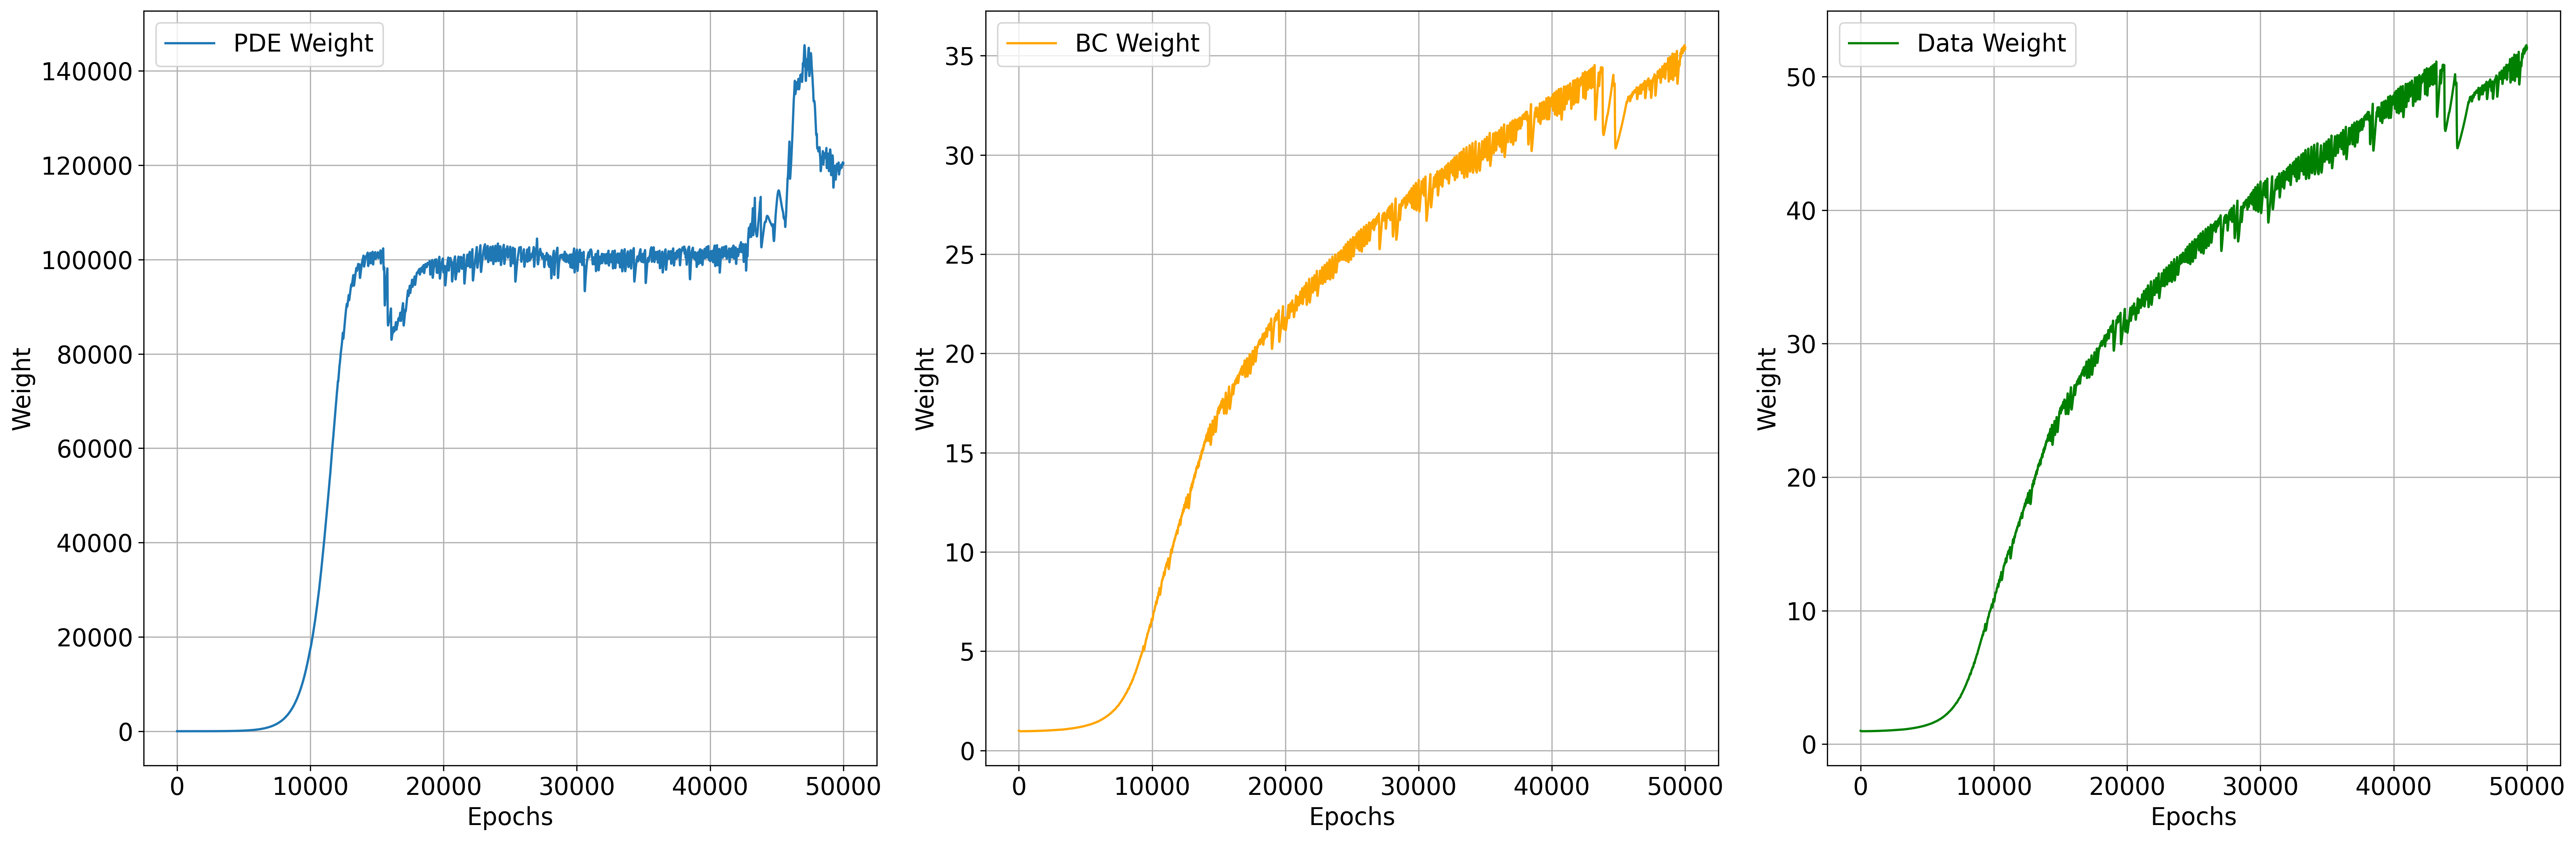

In [12]:
# change the default figure size
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams.update({'font.size': 16})

# Create a figure with one row and three columns
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot 'PDE Weight' in the first subplot (axes[0])
axes[0].plot(loss_weights_hist['PDE_Weight'], label='PDE Weight')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Weight')
axes[0].legend()
axes[0].grid(True)

# Plot 'BC Weight' in the second subplot (axes[1])
axes[1].plot(loss_weights_hist['BC_Weight'], label='BC Weight', color='orange')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Weight')
axes[1].legend()
axes[1].grid(True)

# Plot 'Data Weight' in the third subplot (axes[2])
axes[2].plot(loss_weights_hist['Data_Weight'], label='Data Weight', color='green')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Weight')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()  # You can replace with save if needed

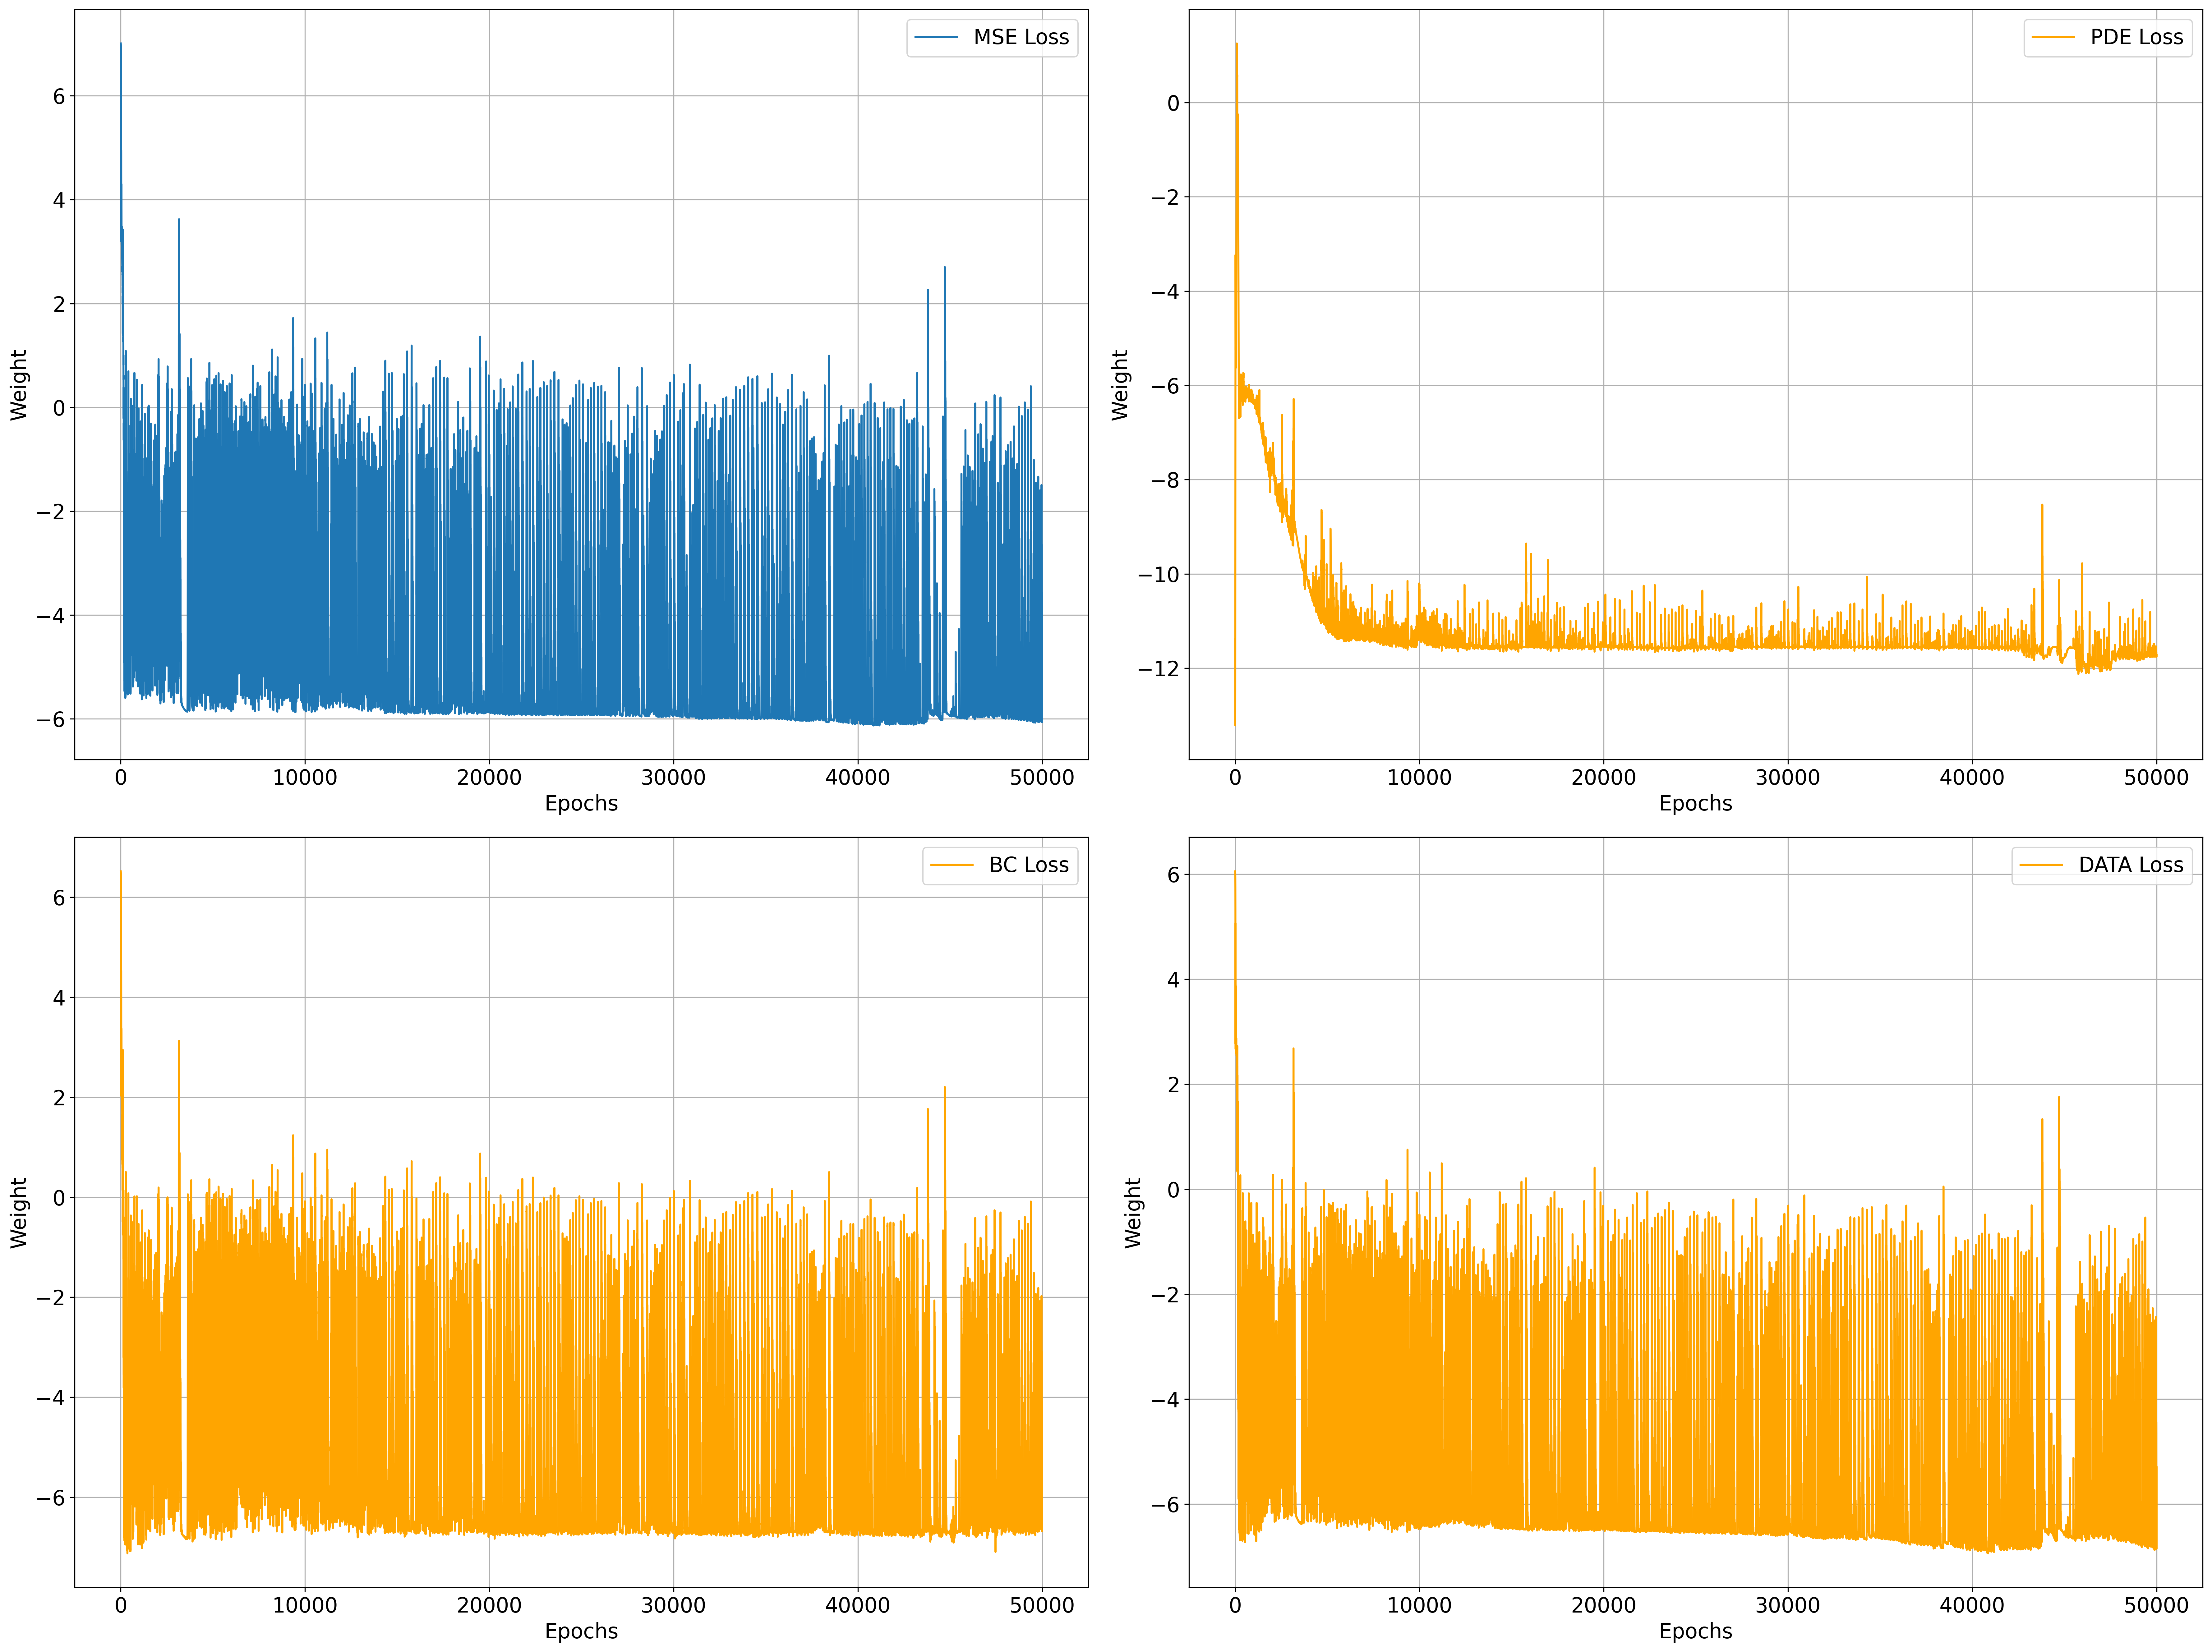

In [13]:
# Create a figure with one row and three columns
fig, axes = plt.subplots(2, 2, figsize=(24, 18))

# Plot 'mse Weight' in the first subplot (axes[0])
axes[0][0].plot(np.log(mse_loss_hist), label='MSE Loss')
axes[0][0].set_xlabel('Epochs')
axes[0][0].set_ylabel('Weight')
axes[0][0].legend()
axes[0][0].grid(True)

# Plot 'pde Weight' in the second subplot (axes[1])
axes[0][1].plot(np.log(pde_loss_hist), label='PDE Loss', color='orange')
axes[0][1].set_xlabel('Epochs')
axes[0][1].set_ylabel('Weight')
axes[0][1].legend()
axes[0][1].grid(True)

# Plot 'bc Weight' in the third subplot (axes[2])
axes[1][0].plot(np.log(bc_loss_hist), label='BC Loss', color='orange')
axes[1][0].set_xlabel('Epochs')
axes[1][0].set_ylabel('Weight')
axes[1][0].legend()
axes[1][0].grid(True)

# Plot 'data Weight' in the third subplot (axes[2])
axes[1][1].plot(np.log(data_loss_hist), label='DATA Loss', color='orange')
axes[1][1].set_xlabel('Epochs')
axes[1][1].set_ylabel('Weight')
axes[1][1].legend()
axes[1][1].grid(True)

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()  # You can replace with save if needed

In [ ]:
import pandas as pd
saved_loss = pd.DataFrame({'training loss': mse_loss_hist, 'relative l2': relative_l2_hist})
saved_loss.to_csv('awipinn_loss_hist.csv')
fig = plt.figure(figsize=(12,12))
plt.plot(range(n_epochs), relative_l2_hist)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('IPINN')